Load dependencies:

In [5]:
# !pip install opensmile
!pip install tensorflow_io
import os
import numpy as np
import librosa
# import opensmile
import math
import scipy
import tensorflow as tf
import tensorflow_io as tfio

directory = "/content/drive/MyDrive/PatientVoiceAI/data"
model_dir = "/content/drive/MyDrive/PatientVoiceAI/saved_models"

Load and preprocess raw audio files in the dataset:

In [7]:
def preprocess(x, chunksize):
    x_len = len(x)
    if x_len < chunksize:   # padding
        processed = np.pad(x, (0,chunksize-x_len))  # right-pad with zero
    elif x_len > chunksize: # splitting
        tailing = x_len % chunksize
        if tailing != 0:                # handle uneven splits: create overlap for the last chunk
            x = np.concatenate((x[:-tailing], x[-chunksize:]))
        num_chunks = int(round(len(x)/chunksize))
        processed = np.array_split(x,num_chunks)
    else:                   # no change
        processed = np.array(x)
    return processed

def get_dataset(label, label_index, chunksize):
    x_set = []
    folder = os.path.join(directory, label)
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f):
            audio, sample_rate = librosa.load(f)
            x_set.append(preprocess(audio,chunksize))
    x_set = np.vstack(x_set)
    y_set = np.repeat([label_index[label]],len(x_set))
    return x_set,y_set


classes = ["coughing", "sneezing", "speech", "silence"]

label_index = {
    "coughing":0,
    "sneezing":1,
    "speech":2,
    "silence":3
}

sample_rate = 22050   # default sample rate in librosa
chunksize = 1*sample_rate   # 1 second


## initialise the dataset
x_set = []
y_set = []
for label in classes:
    x_subset, y_subset = get_dataset(label,label_index,chunksize)
    x_set.extend(x_subset)
    y_set.extend(y_subset)

x_set = np.asarray(x_set).astype('float32')
y_set = np.asarray(y_set)

print(np.shape(x_set))
print(x_set[0])
print(np.shape(y_set))
print(y_set[0])



(13143, 22050)
[0.03695566 0.04142303 0.01117673 ... 0.         0.         0.        ]
(13143,)
0


Store the dataset into a .csv file:

In [8]:
# preprocessed_dataset = np.hstack((x_set, np.expand_dims(y_set,axis=1)))
# np.savetxt('preprocessed_dataset.csv', preprocessed_dataset, fmt="%d", delimiter=",")

Shuffle and split the dataset:

In [9]:
#Parameters for shuffling
seed = 42
np.random.seed(seed)
N = len(y_set)

shuffled_indices = np.random.permutation(N)

# Apply the shuffled indices to both data and labels
x_set = x_set[shuffled_indices]
y_set = y_set[shuffled_indices]


split_size_val = int(0.8*N)
split_size_test = int(0.9*N)

x_train, x_val, x_test = x_set[:split_size_val], x_set[split_size_val:split_size_test], x_set[split_size_test:]
y_train, y_val, y_test = y_set[:split_size_val], y_set[split_size_val:split_size_test], y_set[split_size_test:]

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(10514, 22050)
(1314, 22050)
(1315, 22050)


Define a function to calculate normalised Mel-spectrogram:

In [10]:
def get_normalised_mel_spectrogram(x, sr=sample_rate, n_mel_bins=20):
    """
          Code adapted from https://github.com/douglas125/SpeechCmdRecognition/blob/master/audioUtils.py#L93
    """
    spec_stride = 128
    spec_len = 1024

    spectrogram = tfio.audio.spectrogram(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )

    num_spectrogram_bins = spec_len // 2 + 1  # spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 40.0, 8000.0
    num_mel_bins = n_mel_bins
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    avg = tf.math.reduce_mean(log_mel_spectrograms)
    std = tf.math.reduce_std(log_mel_spectrograms)

    return (log_mel_spectrograms - avg) / std


# testing
# print(get_normalised_mel_spectrogram(x_set[1]))

Define a function to calculate MFCCs:
1. Support deltas
   
   reasoning behind using deltas: https://www.cs.cmu.edu/afs/cs/user/robust/www/Papers/KumarKimSternICA11.pdf
2. Only take first 13?
   
   https://www.quora.com/In-speech-processing-why-do-we-consider-only-first-13-MFCCs

In [ ]:
# kernel_delta_array = np.array([
#         [ 0, 1, 0 ],
#         [ 0, 0, 0 ],
#         [ 0, -1, 0 ]])
# kernel_delta = tf.constant(kernel_delta_array*0.5, dtype=tf.float32)
# kernel_delta = tf.expand_dims(kernel_delta,axis=2)
# kernel_delta = tf.expand_dims(kernel_delta,axis=3)
# print(kernel_delta)

In [12]:
def get_mfccs(x, sr=sample_rate, n=20, deltas=False):

    log_mel_spectrograms = get_normalised_mel_spectrogram(x, sr=sr, n_mel_bins=n)

    ## Compute MFCCs from log_mel_spectrograms and take the first 13
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
    # convert MFCCs into the shape of NHWC format (4D: batch_size, height, width, channels)
    mfccs = tf.expand_dims(mfccs,axis=-1)
    if not deltas:
        return mfccs

    ## calculate delta MFCCs
    # define the kernel in the shape of (4D: filter_height, filter_width, in_channels, out_channels)
    kernel_delta_array = np.array([
        [ 0, 1, 0 ],
        [ 0, 0, 0 ],
        [ 0, -1, 0 ]])
    kernel_delta = tf.constant(kernel_delta_array*0.5, dtype=tf.float32)
    kernel_delta = tf.expand_dims(kernel_delta,axis=2)
    kernel_delta = tf.expand_dims(kernel_delta,axis=3)

    # convolve the kernel with MFCCs
    delta_MFCCs = tf.nn.conv2d(
          mfccs,
          kernel_delta,
          strides = [1,1,1,1],
          padding="SAME")

    ## calculate double delta MFCCs
    # define the kernel in the shape of (4D: filter_height, filter_width, in_channels, out_channels)
    kernel_double_delta_array = np.array([
        [ 0, 0, 2, 0, 0 ],
        [ 0, 0, 1, 0, 0 ],
        [ 0, 0, 0, 0, 0 ],
        [ 0, 0, -1, 0, 0 ],
        [ 0, 0, -2, 0, 0 ]])
    kernel_double_delta = tf.constant(kernel_double_delta_array*0.1, dtype=tf.float32)
    kernel_double_delta = tf.expand_dims(kernel_double_delta,axis=2)
    kernel_double_delta = tf.expand_dims(kernel_double_delta,axis=3)

    # convolve the kernel with MFCCs
    double_delta_MFCCs = tf.nn.convolution(
          mfccs,
          kernel_double_delta,
          strides = [1,1,1,1],
          padding="SAME")

    ## combine the MFCCs with deltas and double deltas
    combined_MFCCs = (tf.concat((mfccs,delta_MFCCs,double_delta_MFCCs),axis=2))

    return combined_MFCCs

# testing
# print(get_mfccs([x_set[1]],deltas=True))

tf.Tensor(
[[[[-1.1391327e+00]
   [ 4.5120702e+00]
   [ 8.9796460e-01]
   ...
   [-8.4176324e-02]
   [-5.4025456e-02]
   [ 1.9546568e-02]]

  [[-8.6550301e-01]
   [ 4.4316506e+00]
   [ 8.2762676e-01]
   ...
   [-7.2255053e-02]
   [-1.3231782e-02]
   [ 6.5542944e-02]]

  [[-5.8968824e-01]
   [ 4.1779132e+00]
   [ 6.7887598e-01]
   ...
   [-8.9412704e-03]
   [ 6.5258205e-02]
   [ 9.1923885e-02]]

  ...

  [[-8.1044227e-01]
   [ 2.5797966e+00]
   [ 2.7624258e-01]
   ...
   [ 7.7299535e-02]
   [ 1.1543093e-02]
   [-6.2442971e-03]]

  [[-6.1357007e+00]
   [ 2.3233545e+00]
   [ 4.0918165e-01]
   ...
   [ 6.3506462e-02]
   [ 4.5327272e-02]
   [-5.1596239e-03]]

  [[-2.3010492e+01]
   [ 4.9411267e-02]
   [-6.2049234e-01]
   ...
   [ 3.1159768e-02]
   [ 5.7488121e-02]
   [-3.6790131e-03]]]], shape=(1, 173, 39, 1), dtype=float32)


Build a model:

In [13]:
"""
      Code adapted from https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py
"""

from tensorflow import keras
from keras import layers as L
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers
from keras.models import Model, load_model


def get_melspec_model(iLen=None):
    inp = L.Input((iLen,), name='input')
    mel_spec = get_normalised_mel_spectrogram(inp)
    melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalised_spectrogram_model')
    return melspecModel

def get_mfccs_model(iLen=None):
    inp = L.Input((iLen,), name='input')
    mfccs = get_mfccs(inp, deltas=True)
    mfccsModel = Model(inputs=inp, outputs=mfccs, name='normalised_mfccs_model')
    return mfccsModel

def AttRNNSpeechModel(nCategories, samplingrate=sample_rate,
                      inputLength=chunksize, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength

    inputs = L.Input((inputLength,), name='input')

    # m =  get_melspec_model(iLen=inputLength)
    m =  get_mfccs_model(iLen=inputLength)
    m.trainable = False

    x = m(inputs)
    # x = tf.expand_dims(x, axis=-1, name='mel_stft')   # only required for mel-spectrograms

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    # xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    # query = L.Dense(128)(xFirst)

    # # dot product attention
    # attScores = L.Dot(axes=[1, 2])([query, x])
    # attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # # rescale sequence
    # attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    # for classification
    x = L.GlobalAveragePooling1D()(x)
    x = L.Dense(64, activation='relu')(x)      #(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

Create a model:

In [14]:
nCategs = len(classes)
model = AttRNNSpeechModel(nCategs, samplingrate = sample_rate, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 normalised_mfccs_model (Fu  (None, None, 39, 1)       0         
 nctional)                                                       
                                                                 
 conv2d (Conv2D)             (None, None, 39, 10)      60        
                                                                 
 batch_normalization (Batch  (None, None, 39, 10)      40        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, None, 39, 1)       51        
                                                                 
 batch_normalization_1 (Bat  (None, None, 39, 1)       4     

Train the model:

In [15]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate

model_name = 'model-delta-mfccs-RNN.h5'
model_path = os.path.join(model_dir, model_name)
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(model_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), use_multiprocessing=False,
                    callbacks=[earlystopper, checkpointer, lrate])



Changing learning rate to 0.001
Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.3263 - sparse_categorical_accuracy: 0.8835
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.86910, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-delta-mfccs-RNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - 221s 640ms/step - loss: 0.3263 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.4366 - val_sparse_categorical_accuracy: 0.8691 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1459 - sparse_categorical_accuracy: 0.9522
Epoch 2: val_sparse_categorical_accuracy improved from 0.86910 to 0.94673, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-delta-mfccs-RNN.h5
329/329 [==============================] - 211s 641ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1718 - val_sparse_categorical_accuracy: 0.9467 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1058 - sparse_categorical_accuracy: 0.9644
Epoch 3: val_sparse_categorical_accuracy improved from 0.94673 to 0.95129, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-delta-mfccs-RNN.h5


Plot the training history:

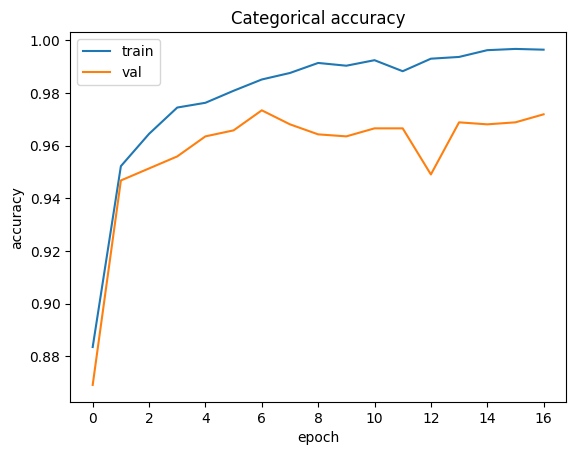

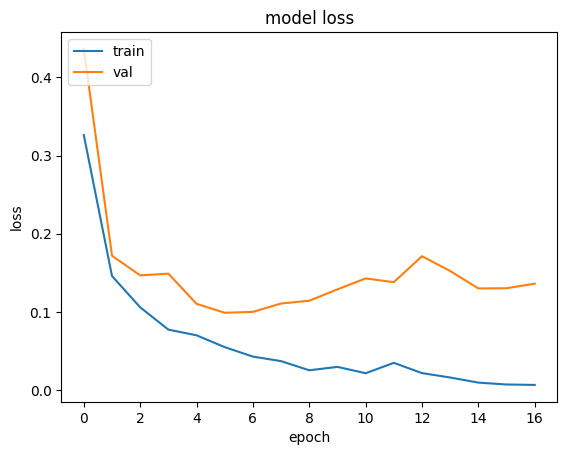

In [16]:
import matplotlib.pyplot as plt

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load the previously saved weights:

In [17]:
## load the previously saved weights
# model_name = 'model-delta-mfccs-RNN.h5'
# model_path = os.path.join(model_dir, model_name)
model.load_weights(model_path)

Evaluate on the test set:

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12314768880605698
Test accuracy: 0.9665399193763733


Perform predictions on the test set and calculate the confusion matrix:

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred,1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

42/42 [==============================] - 10s 185ms/step
[[549   4   6   2]
 [  9  80   3   2]
 [ 12   5 632   1]
 [  0   0   0  10]]


Function to predict for an external audio:

In [20]:
classes = np.asarray(classes)

def predict_framewise(x, chunksize=chunksize, model=model):
    # preprocess the input audio
    x = np.asarray(preprocess(x, chunksize)).astype('float32')
    # feed it into the model to produce predictions
    y_pred = model.predict(x)
    y_pred_probs = np.max(y_pred, axis=1)   # the probability of the highest scoring class
    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_pred_labels = classes[y_pred_categorical]   # the label of the highest scoring class
    return y_pred_labels, y_pred_probs

A plotter to plot the prediction result for the audio:

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter

class TimescalePlotter:
    def __init__(self, time_values:list, label_values:list, prob_values:list, filename:str, gold_label:str, color_map={'coughing': 'red', 'sneezing': 'blue', 'speech': 'green', 'silence': 'grey'}):
        data = {
            'Time': time_values,
            'Label': label_values,
            'Probability': prob_values,
        }
        if len(time_values) != len(label_values):
            print(len(time_values))
            print(len(label_values))
        self.df = pd.DataFrame(data)
        self.color_map = color_map
        self.intervals = self._get_intervals()
        self.merged_intervals = self._merge_intervals()     # neglecting probs
        self.title = "Gold label: "+gold_label
        self.filename = filename[:-4]

    def _merge_intervals(self):
        merged_intervals = []
        current_label = self.df['Label'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            if self.df['Label'].iloc[i] != current_label:
                merged_intervals.append((start_time, self.df['Time'].iloc[i], current_label))
                current_label = self.df['Label'].iloc[i]
                start_time = self.df['Time'].iloc[i]

        # Add the last interval
        merged_intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label))
        return merged_intervals

    def _get_intervals(self):
        intervals = []
        current_label = self.df['Label'].iloc[0]
        current_prob = self.df['Probability'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            intervals.append((start_time, self.df['Time'].iloc[i], current_label, current_prob))
            current_label = self.df['Label'].iloc[i]
            current_prob = self.df['Probability'].iloc[i]
            start_time = self.df['Time'].iloc[i]

        # Add the last interval
        intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label, current_prob))
        return intervals

    def plot(self, figsize=(20, 2)):
        fig, ax = plt.subplots(figsize=figsize)  # Adjust the height by setting figsize to (width, height)

        ## Add colored intervals regardless of probabilities
        # for start_time, end_time, label in self.merged_intervals:
        #     ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=0.3, label=label)

        # Add colored intervals with transparencies corresponding to probabilities
        for start_time, end_time, label, prob in self.intervals:
            ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=prob, label=label)

        # Add dummy entries for labels not present in data
        for label, color in self.color_map.items():
            if label not in self.df['Label'].unique():
                ax.axvspan(np.NaN, np.NaN, color=color, alpha=0.3, label=label)

        # Formatting the plot
        ax.set_xlim(self.df['Time'].min() - 1, self.df['Time'].max() + 2)  # Adjust x-axis limits
        ax.set_ylim(0.5, 1.5)  # Adjust y-axis limits to focus on the labels
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Label')
        ax.set_title(self.title)  # Set the plot title

        # Customizing ticks and grid
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show up to 10 major ticks on the x-axis
        ax.yaxis.set_visible(False)  # Hide y-axis
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

        # Create a legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        # Display the plot
        plt.show()

Test an example of an external audio:

4/4 [==============================] - 1s 233ms/step
['speech' 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech' 'speech'
 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech' 'speech'
 'coughing' 'speech' 'speech' 'speech' 'speech' 'coughing' 'speech'
 'coughing' 'speech' 'speech' 'coughing' 'coughing' 'coughing' 'silence'
 'coughing' 'coughing' 'sneezing' 'speech' 'speech' 'speech' 'coughing'
 'speech' 'speech' 'coughing' 'speech' 'speech' 'sneezing' 'speech'
 'sneezing' 'sneezing' 'sneezing' 'coughing' 'coughing' 'speech' 'speech'
 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'sneezing' 'speech'
 'speech' 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech'
 'coughing' 'sneezing' 'silence' 'speech' 'sneezing' 'sneezing' 'sneezing'
 'coughing' 'sneezing' 'speech' 'speech' 'speech' 'coughing' 'speech'
 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech'
 'speech' 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech' 'speech'
 'speech' 'speech

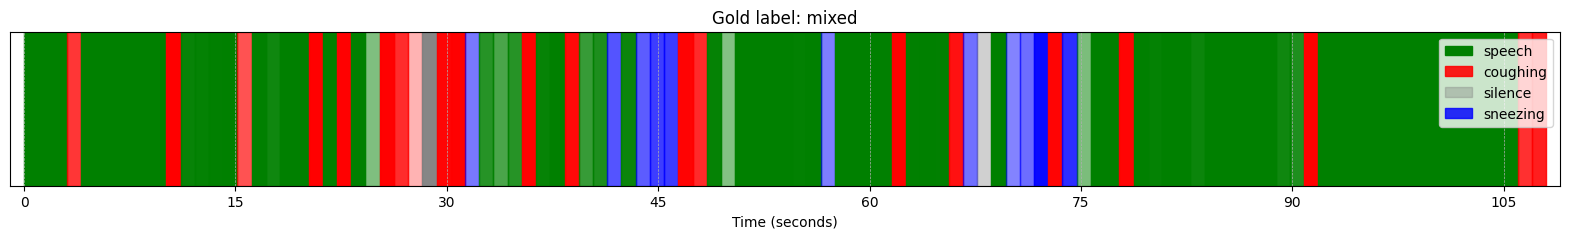

In [22]:
# testing
eg_label = "mixed"
eg_filename = "qPo0bymnsh0.wav"
eg_f = os.path.join(directory, eg_label, eg_filename)
eg_x, eg_sr = librosa.load(eg_f)
eg_y_labels, eg_y_probs = predict_framewise(eg_x)
print(eg_y_labels)
print(eg_y_probs)

chunk_duration = 1.0   # in second

eg_audio_duration = chunk_duration*len(eg_y_labels)
eg_timestamps = np.linspace(start=0, stop=eg_audio_duration, num=len(eg_y_labels))
plotter = TimescalePlotter(list(eg_timestamps), list(eg_y_labels), list(eg_y_probs), eg_filename, eg_label)
plotter.plot()
